In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import keras
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.utils import shuffle
%matplotlib inline

In [1]:
# load positive labels
pos = open('Dataset/Positive_tweets(10000).csv').read()
npos = 0
labels, texts = [], []
for i, line in enumerate(pos.split("\n")):
    content = line.split(',')
    if len(content) < 4:
    	continue;
    if content[4] != "English":
    	continue;
    labels.append(1)
    texts.append(content[2])
    npos += 1

# load negative labels (random tweets)
neg = open('Dataset/Negative_tweets(10000).txt').read()
nneg = 0
for i, line in enumerate(neg.split("\n")):
    labels.append(0)
    texts.append(line)
    nneg += 1

texts, labels = shuffle(texts, labels)

print('Total number of datapoints: ', len(labels))
print('Positive labels: ', npos)
print('Negative labels: ', nneg)

df = pd.DataFrame()
df['text'] = texts
df['label'] = labels

df.head()

NameError: name 'shuffle' is not defined

Text(0.5, 1.0, 'Breakdown by label type')

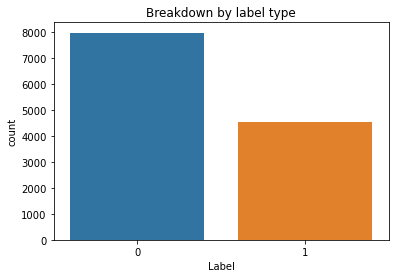

In [34]:
sns.countplot(df.label)
plt.xlabel('Label')
plt.title('Breakdown by label type')

In [47]:
enc = LabelEncoder()
y = enc.fit_transform(labels).reshape(-1,1)
train_x, test_x, train_y, test_y = train_test_split(df['text'], y, test_size=0.20)

# Tokenize the text. Max length 280 (may tweak)

maxlen = 280
maxwords = 10000

token = Tokenizer(num_words=maxwords)
token.fit_on_texts(df['text'])

sequences = token.texts_to_sequences(train_x)
padded = sequence.pad_sequences(sequences, maxlen=maxlen)

10011


In [38]:
def make_rnn():
    inputs = Input(name='inputs',shape=[maxlen])
    layer = Embedding(maxwords,50,input_length=maxlen)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

model = make_rnn()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 280)]             0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 280, 50)           500000    
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_8 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257 

In [48]:
history = model.fit(padded,train_y,epochs=10,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Epoch 1/10
63/63 [==============================] - 17s 230ms/step - loss: 0.5153 - accuracy: 0.7326 - val_loss: 0.1439 - val_accuracy: 0.9496
Epoch 2/10
63/63 [==============================] - 14s 228ms/step - loss: 0.1101 - accuracy: 0.9570 - val_loss: 0.1257 - val_accuracy: 0.9576
Epoch 3/10
63/63 [==============================] - 14s 229ms/step - loss: 0.0683 - accuracy: 0.9772 - val_loss: 0.1515 - val_accuracy: 0.9461


In [52]:
test_sequences = token.texts_to_sequences(test_x)
test_padded = sequence.pad_sequences(test_sequences,maxlen=maxlen)

accuracy = model.evaluate(test_padded, test_y)
print('Test loss: ', accuracy[0])
print('Test accuracy: ', accuracy[1])



79/79 [==============================] - 2s 27ms/step - loss: 0.1433 - accuracy: 0.9417
Test loss:  0.143338143825531
Test accuracy:  0.9416700005531311


In [30]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


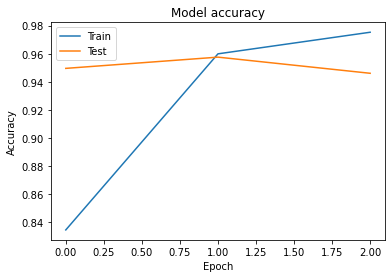

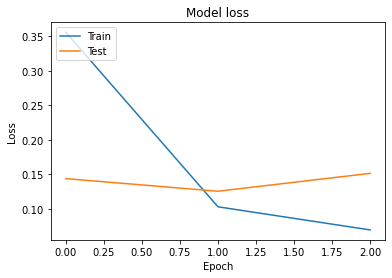

In [53]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()